In [1]:
push!(LOAD_PATH,"C:/JMB/DINEOF.jl/src","."); using DINEOF
using PyPlot
using LinearAlgebra
using Arpack
using Statistics
using Optim
using Random

┌ Info: Recompiling stale cache file C:\Users\jmbeckers\.julia\compiled\v1.2\DINEOF.ji for DINEOF [top-level]
└ @ Base loading.jl:1240


In [2]:
?DINEOF_pmQC

search: DINEOF_pmQC DINEOF_errormap



```
  OutlierIndicator=DINEOF_pmQC(X,XA,errmap,musquare,ws;weights=[1.0,1.0,1.0],statmeth="meanstd")
```

# Outlier detection

# Input:

  * `X`: an NDimensional array of original data with NaN at missing points
  * `XA` : an NDimensional array which contains the analysed field (the EOF reconstruction) at all points (present and absent points)
  * `errmap` : an NDimensional array containing the error variance estimate. If errmap=[] the outlier detection based on residuals is not exploited
  * `musquare`: estimated value (effective) musquare
  * `ws`: width of the window for outlier detection based on data variance. the box size is (2*ws+1)^NDIMS
  * `weights` : array of weights for the three outlier indicators (residuals, proximity to NaNs, data variability). If a weight is zero the corresponding indicator is not calculated. weights are normalized internally to have a sum of 1
  * `statmeth`: if "meanstd" mean and std are used, otherwise median and MAD (much slower)

# Output:

  * `OutlierIndicator` : an ND array with the same topology as X with values indicating suspect data with high values.


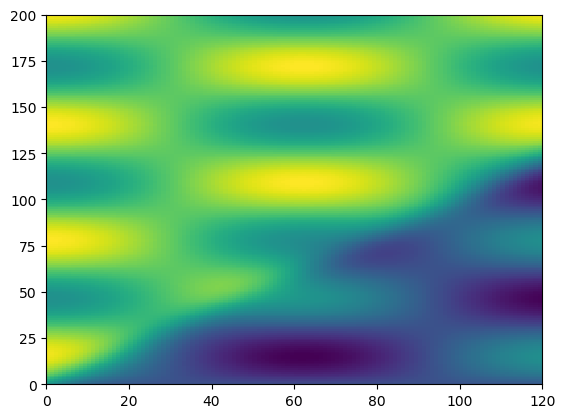

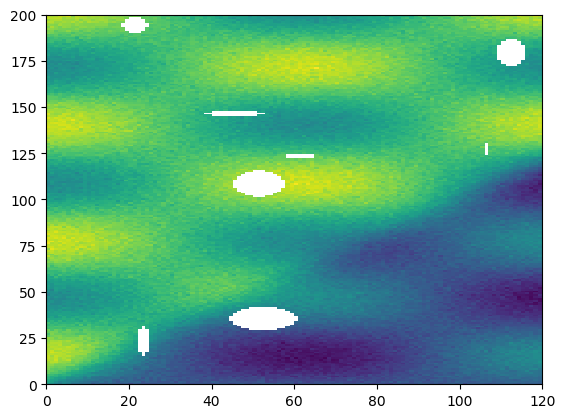

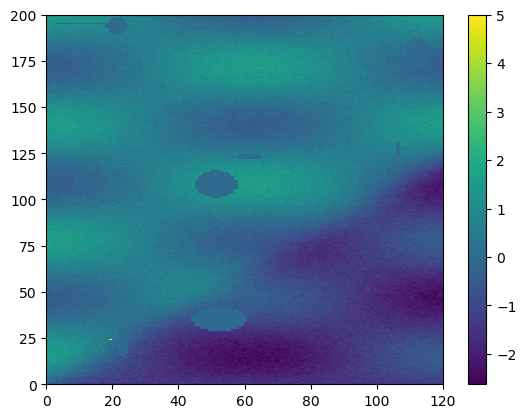

200×120 Array{Float64,2}:
 -0.178066  -0.362476    -0.588074   …  -1.28785   -1.24475   -1.36729 
  0.106105  -0.0386934   -0.326315      -1.13989   -1.15878   -1.23778 
  0.20999   -0.00555569  -0.0717456     -1.16296   -0.977637  -1.11429 
  0.329384   0.177443    -0.0274573     -1.0454    -1.05285   -1.10414 
  0.422306   0.242423     0.301651      -1.03959   -0.87018   -1.04932 
  0.562781   0.51117      0.377861   …  -0.884215  -0.864633  -0.944433
  0.881757   0.688606     0.701141      -0.679713  -0.855476  -0.92082 
  0.916477   0.911519     0.789943      -0.866861  -0.832635  -0.919546
  1.07696    0.849146     0.782391      -0.544556  -0.491064  -0.778104
  1.14049    1.01772      0.907583      -0.642487  -0.744445  -0.610877
  1.22095    1.16624      1.00459    …  -0.533931  -0.674717  -0.52275 
  1.25018    1.32168      1.15645       -0.602017  -0.42212   -0.416969
  1.31031    1.44421      1.48154       -0.539725  -0.503403  -0.293525
  ⋮                                  ⋱

In [3]:
Random.seed!(123)

NX=200
NY=120
X=zeros(Float64,NX,NY)
      for j=1:NY
            for i=1:NX
        X[i,j]=sin(i/10)*cos(j/20)+tanh((i-j)/10)
            end
        end
X.=X.-mean(X)
pcolor(X)
figure()
# use cvmask routing to create some bubbles and missing points
X=X+0.1*randn(size(X))
cvmask=DINEOF_cvmask(X,0.02,cvmethod="Bubbles",maxbubblesize=[20,20])
X[cvmask].=NaN
# Now real cv mask
cvmask=DINEOF_cvmask(X,0.05,cvmethod="Bubbles",maxbubblesize=[20,20])
pcolor(X)
NM=sum(isnan.(X))
missingvalues=zeros(Int,(NM,2))
    icount=0
    for j=1:size(X)[2]
        for i=1:size(X)[1]
            if isnan(X[i,j])
                icount=icount+1
                missingvalues[icount,1]=i
                missingvalues[icount,2]=j
                # Put a random value with average variance of present data so that we can keep an eye on how total variane
                # behaves.
                X[i,j]=0
            end
        end
    end
cvpoints=zeros(Int,(sum(cvmask),2))
    icount=0
    for j=1:size(X)[2]
        for i=1:size(X)[1]
        if  cvmask[i,j]
                icount=icount+1
                cvpoints[icount,1]=i
                cvpoints[icount,2]=j
                
            end
        end
    end
X[25,20]=5
figure()
pcolor(X),colorbar()
XORI=deepcopy(X)

svds!: variance and mean of the entry matrix: 0.9726823389763631 , -0.004730356324321747 ; intial variance at points to fill in: 2.2376270955050975e-5 


┌ Warning: You should subtract a mean value from your data
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:96


Convergence for 1 eofs, relative change 0.0007303741488959629 after 6 iterations
Eof loop 1 with mean squared misfit: 0.30211925388511707 
Convergence for 2 eofs, relative change 0.0008514158228001206 after 8 iterations
Eof loop 2 with mean squared misfit: 0.18388110230786361 
Eof loop 3 with mean squared misfit: 0.07242886982679239 
Eof loop 4 with mean squared misfit: 0.03947240785633772 
Convergence for 5 eofs, relative change 0.0008784354293776246 after 10 iterations
Eof loop 5 with mean squared misfit: 0.03348239563944353 
Cross validation value (mean squared misfit): 0.03348239563944353 for 5 EOFs
Estimation for musquare based on DeRozier type of analysis: 0.01600207951534558
Estimation of mean error variance of reconstuctions: -0.01748031612409795 


┌ Warning: Initial Variance has been increased for filtered matrix  by factor 1.0046400925159993
└ @ DINEOF C:\JMB\DINEOF.jl\src\DINEOF_svds!.jl:285


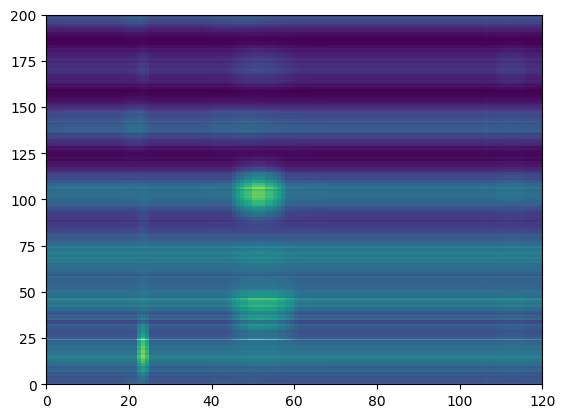

  8.597401 seconds (19.40 M allocations: 966.971 MiB, 5.80% gc time)


PyObject <matplotlib.collections.PolyCollection object at 0x0000000038A6E3C8>

In [4]:
@time U,S,V,cv,cva,mus=DINEOF_svds!(X,missingvalues,cvpoints;ncmax=5)
errm=DINEOF_errormap(U,S,V,mus,missingvalues)
pcolor(errm)

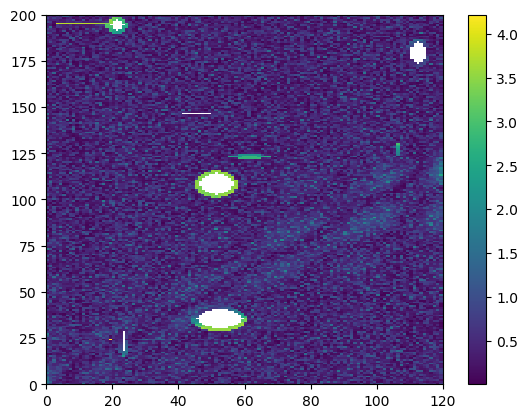

(PyObject <matplotlib.collections.PolyCollection object at 0x0000000036759240>, PyObject <matplotlib.colorbar.Colorbar object at 0x00000000376B6C18>)

In [5]:
XA=U*diagm(S)*V'
OO=DINEOF_pmQC(XORI,XA,errm,mus,1)
pcolor(OO),colorbar()